In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="0"

Sun Jun 30 16:56:18 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4090        Off |   00000000:19:00.0 Off |                  Off |
|  0%   40C    P8             26W /  450W |      11MiB /  24564MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
import os

import numpy as np
import torch as th

from guided_diffusion import dist_util, logger
from guided_diffusion.script_util import (
    NUM_CLASSES,
    model_and_diffusion_defaults,
    create_model_and_diffusion,
    add_dict_to_argparser,
    args_to_dict,
)

In [4]:
from easydict import EasyDict
defaults = EasyDict(
    clip_denoised=True,
    num_samples=10000,
    batch_size=16,
    use_ddim=False,
    model_path="",
)
defaults.update(model_and_diffusion_defaults())

args = defaults
args.attention_resolutions = "32,16,8"
args.class_cond = False
args.diffusion_steps = 1000
args.dropout = 0.1 
args.image_size = 64 
args.learn_sigma = False
args.noise_schedule = 'cosine'
args.num_channels = 192 
args.num_head_channels = 64 
args.num_res_blocks = 3 
args.resblock_updown = True
args.use_new_attention_order = True
args.use_fp16 = True
args.use_scale_shift_norm = True


In [5]:
!ls -lt /data/openai_log/64x64_fm_warm6

total 27672784
-rw-rw-r-- 1 scpark scpark    1970122  4월 26 16:41 log.txt
-rw-rw-r-- 1 scpark scpark     936128  4월 26 16:41 progress.csv
-rw-rw-r-- 1 scpark scpark 2361052375  4월 26 14:40 opt780000.pt
-rw-rw-r-- 1 scpark scpark 1180631655  4월 26 14:40 ema_0.9999_780000.pt
-rw-rw-r-- 1 scpark scpark 1180631655  4월 26 14:40 model780000.pt
-rw-rw-r-- 1 scpark scpark 2361052375  4월 26 12:41 opt770000.pt
-rw-rw-r-- 1 scpark scpark 1180631655  4월 26 12:41 ema_0.9999_770000.pt
-rw-rw-r-- 1 scpark scpark 1180631655  4월 26 12:41 model770000.pt
-rw-rw-r-- 1 scpark scpark 2361052375  4월 26 10:28 opt760000.pt
-rw-rw-r-- 1 scpark scpark 1180631655  4월 26 10:28 ema_0.9999_760000.pt
-rw-rw-r-- 1 scpark scpark 1180631655  4월 26 10:28 model760000.pt
-rw-rw-r-- 1 scpark scpark 2361052375  4월 26 08:07 opt750000.pt
-rw-rw-r-- 1 scpark scpark 1180631655  4월 26 08:07 ema_0.9999_750000.pt
-rw-rw-r-- 1 scpark scpark 1180631655  4월 26 08:07 model750000.pt
-rw-rw-r-- 1 scpark scpark 2361052375  4월 26 05:46 opt

In [6]:
device = 'cuda:0'
model, diffusion = create_model_and_diffusion(
        **args_to_dict(args, model_and_diffusion_defaults().keys())
    )
model = model.to(device)

model_path = '/data/openai_log/64x64_fm_warm6/ema_0.9999_780000.pt'
checkpoint = th.load(model_path, map_location='cpu')
model.load_state_dict(checkpoint)
model.convert_to_fp16()
model.eval()
print('done')

done


### Euler

In [7]:
from tqdm import tqdm

T = 100
dt = 1/T
x = torch.randn(10, 3, args.image_size, args.image_size).to(device)

with torch.no_grad():
    for i in tqdm(range(T)):
        t_tensor = torch.ones((len(x),)).to(device) * i/T
        pred = model(x, t_tensor)
        x = x.detach() + pred * dt

x = ((x + 1) * 127.5).clamp(0, 255).to(th.uint8)
x = x.permute(0, 2, 3, 1)
x = x.contiguous()
x = x.data.cpu().numpy()
print(x.shape)

100%|█████████████████████████████████████████| 100/100 [00:06<00:00, 14.92it/s]

(10, 64, 64, 3)


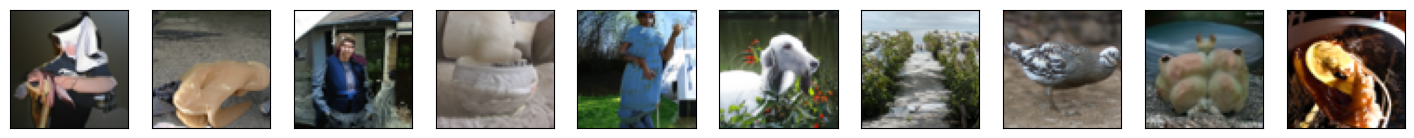

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=[18, 5])
for i in range(len(x)):
    plt.subplot(1, len(x), i+1)
    plt.imshow(x[i])
    plt.xticks([])
    plt.yticks([])
plt.show()

### Ancestral

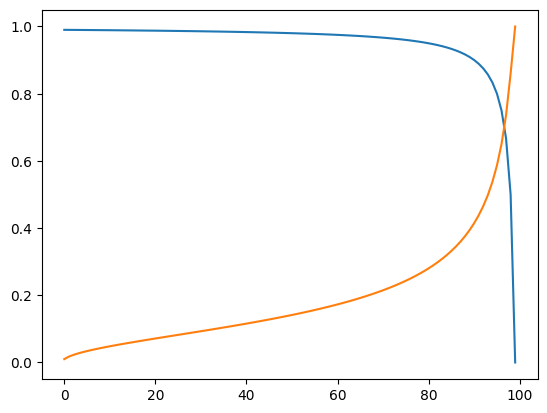

In [40]:
T = 100

def make_a_list(T):
    a_list = np.zeros(T)
    for t in range(1, T+1):
        a_list[t-1] = (1 - t/T) / (1 - (t-1)/T)
    return a_list

def make_b_list(T):
    b_list = np.zeros(T)
    b_list[0] = 1/T
    for t in range(2, T+1):
        result = (t/T)**2
        for s in range(1, t):
            result = result - (b_list[s-1] * (1-t/T)/(1-s/T)) ** 2
        b_list[t-1] = np.sqrt(result)
    return b_list

a_list = make_a_list(T)
b_list = make_b_list(T)

plt.plot(a_list)
plt.plot(b_list)
plt.show()

In [41]:
def get_noise_coeff(t, T=100):
    if t == T:
        return 1
    l = np.array([b_list[k-1] * (1 - t/T) / (1 - k/T) for k in range(1, t+1)])
    result = np.sqrt(np.sum(l ** 2))
    return result

signal_rate = np.cumprod(a_list)
noise_rate = [get_noise_coeff(t, T) for t in range(1, T+1)]

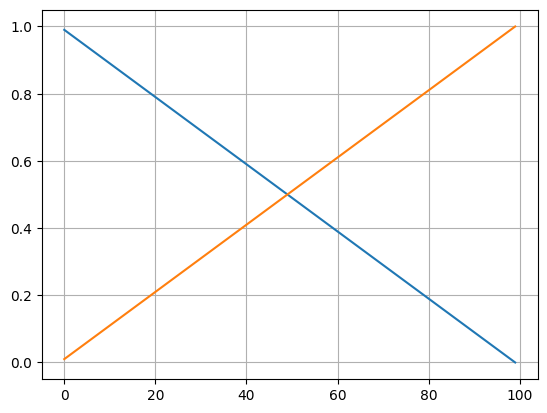

In [42]:
plt.plot(signal_rate)
plt.plot(noise_rate)
plt.grid()
plt.show()

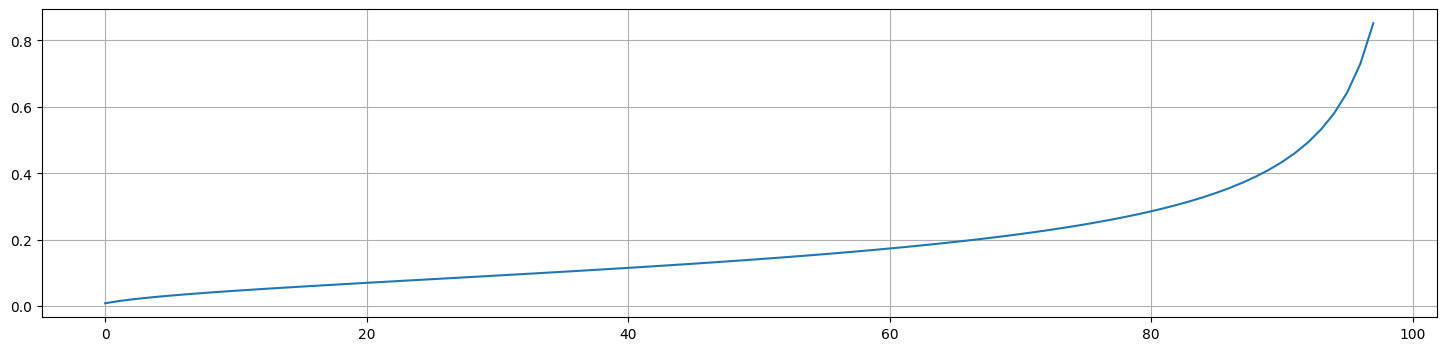

In [43]:
def scale(t, T=100):
    return (T - t) / T

def sigma(t, T=100):
    return t / T

def get_Sigma(t, T=100):
    if t == 1:
        return 0
    return 1 / (1 / sigma(t-1, T)**2 + a_list[t-1]**2 / b_list[t-1]**2)

plt.figure(figsize=[18, 4])
plt.plot([np.sqrt(get_Sigma(t)) for t in range(2, T)])
plt.grid()
plt.show()

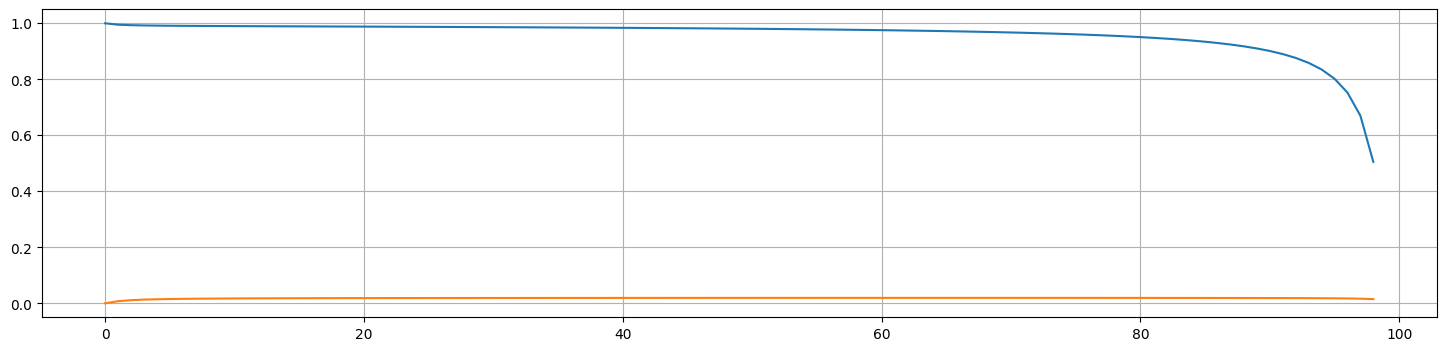

In [44]:
def post_prev_rate(t, T=100):
    rate = (a_list[t-1] * sigma(t-1, T)**2 + scale(t-1, T) * b_list[t-1]**2) / (b_list[t-1]**2 + a_list[t-1]**2 * sigma(t-1, T)**2)
    return rate
    
def post_flow_rate(t, T=100):
    rate = (t-1)/T * (scale(t-1, T) * b_list[t-1]**2) / (b_list[t-1]**2 + a_list[t-1]**2 * sigma(t-1, T)**2)
    return rate

plt.figure(figsize=[18, 4])
plt.plot([post_prev_rate(t) for t in range(1, T)])
plt.plot([post_flow_rate(t) for t in range(1, T)])
plt.grid()
#plt.ylim([0, 1])
plt.show()

In [45]:
from tqdm import tqdm

dt = 1/T
x_t = torch.randn(10, 3, args.image_size, args.image_size).to(device)

with torch.no_grad():
    for t in tqdm(range(T)):
        # 0 to 1
        t_tensor = torch.ones((len(x_t),)).to(device) * t/T
        v_t = model(x_t, t_tensor)
        
        # T to 1
        t_rev = T - t
        Sigma = get_Sigma(t_rev, T)
        prev_rate = post_prev_rate(t_rev, T)
        flow_rate = post_flow_rate(t_rev, T)
        x_t = x_t.detach()*prev_rate + v_t*flow_rate + torch.randn_like(x_t)*np.sqrt(Sigma)

x = ((x_t + 1) * 127.5).clamp(0, 255).to(th.uint8)
x = x.permute(0, 2, 3, 1)
x = x.contiguous()
x = x.data.cpu().numpy()
print(x.shape)

100%|█████████████████████████████████████████| 100/100 [00:04<00:00, 23.26it/s]

(10, 64, 64, 3)


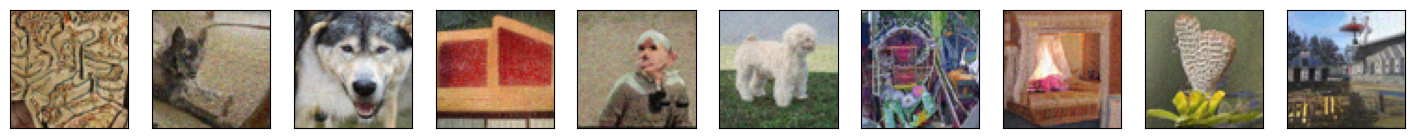

In [46]:
import matplotlib.pyplot as plt
plt.figure(figsize=[18, 5])
for i in range(len(x)):
    plt.subplot(1, len(x), i+1)
    plt.imshow(x[i])
    plt.xticks([])
    plt.yticks([])
plt.show()